Here we will run connectivity analysis using atlas
1. Load an atlas (can try some)
2. mask and fit images to this atlas
3. Create correlation matrix (or vector) 
4. Check prediction / correlate to PCL?

In [ ]:
from nilearn import datasets
import os
from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image


In [ ]:
def removeVars (confoundFile):
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf', 'white_matter', 'global_signal',
                          'a_comp_cor_00', 'a_comp_cor_01',	'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 
                        'a_comp_cor_05', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
 
    return finalConf

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

In [ ]:
subList =  ['008', '1253' , '1293' ,'1307','1322','1339','1343','1387'] #'1223'
midSubList = ['1253','1263','1351','1364','1369','1390','1403']

subject_list = np.concatenate([subList,midSubList])
rest_files_1 = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-1/func/sub-%s_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (sub,sub) for sub in subList]

confound_files_1 = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-1/func/sub-%s_ses-1_task-rest_desc-confounds_regressors.tsv' % (sub,sub) for sub in subList]


rest_files_2 = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-2/func/sub-%s_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (sub,sub) for sub in subList]

confound_files_2 = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-2/func/sub-%s_ses-2_task-rest_desc-confounds_regressors.tsv' % (sub,sub) for sub in subList]
kpe_label = [1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2]

rest_files = np.concatenate([rest_files_1, rest_files_2])
confound_files = np.concatenate([confound_files_1, confound_files_2])

In [ ]:
# load atlas
#%% Using atlas instead of dictionary learning
#allen = datasets.fetch_atlas_allen_2011()
#atlas = datasets.fetch_atlas_msdl()
#atlas_filename = atlas['maps']
#atlas_filename
#labels = atlas.networks
#labels

#oxfordAt = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
#atlas_filename = oxfordAt.maps
#labels = oxfordAt.labels

msdl_data = datasets.fetch_atlas_msdl()
atlas_filename = msdl_data.maps
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))


In [ ]:
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
# create masker to extract functional data within atlas parcels
#from nilearn.input_data import NiftiLabelsMasker
#
#masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
#                           memory="/home/oad4/scratch60/nilearn", high_pass=.01 , low_pass = .1, t_r=1)
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                          memory="/home/oad4/scratch60/nilearn", high_pass=.01 , low_pass = .1, t_r=1)
masker

In [6]:
kpe_subjects = []
total_subjects = []

for func_file, confound_file, phenotypic in zip(
        rest_files, confound_files, kpe_label):
    confoundClean = removeVars(confound_file)
    confoundArray = confoundClean.values
    time_series = masker.fit_transform(func_file, confounds=confoundArray)
    #time_series = extractor.fit_transform(func_file, confounds=confoundArray)
    #masker.fit_transform(func_file, confoundArray)
    total_subjects.append(time_series)
    if phenotypic == 1:
        kpe_subjects.append(time_series)


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/home/oad4/scratch60/nilearn'", use "location='/home/oad4/scratch60/nilearn'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is curre

In [7]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
tangent_measure = ConnectivityMeasure(kind='tangent')


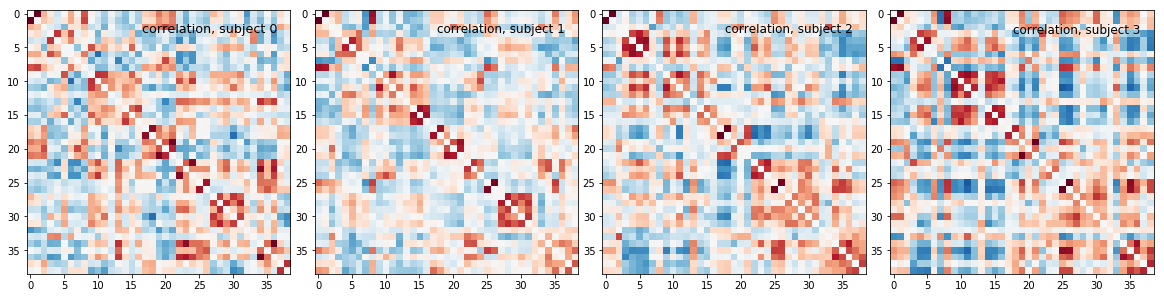

In [8]:
correlation_matrices = correlation_measure.fit_transform(kpe_subjects)
plot_matrices(correlation_matrices[:4], 'correlation')

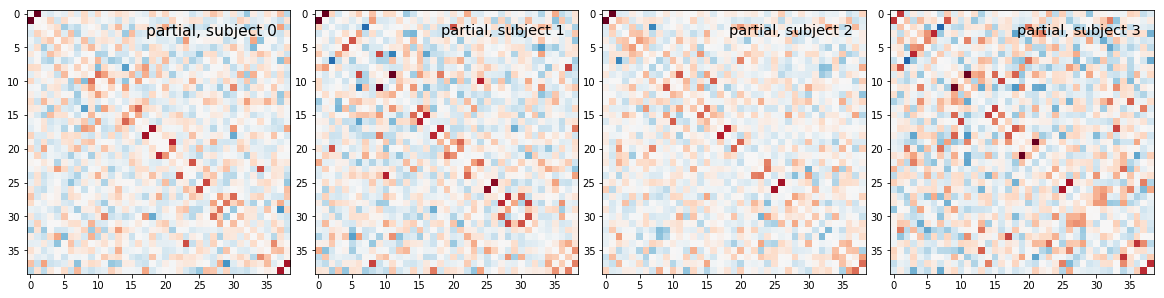

In [9]:
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    kpe_subjects)
plot_matrices(partial_correlation_matrices[:4], 'partial')

In [10]:
tangent_matrices = tangent_measure.fit_transform(kpe_subjects)


In [11]:
connectivity_biomarkers = {}
kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(total_subjects)

len(total_subjects)
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))


780 correlation biomarkers for each subject.


In [12]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3)

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=kpe_label,
                                cv=cv,
                                groups=kpe_label,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

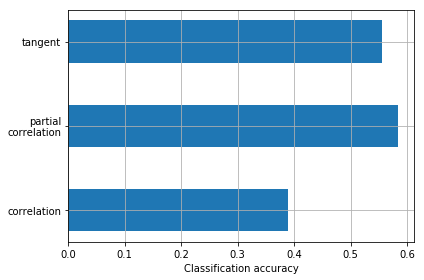

In [14]:
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()


In [15]:
# using sparse inverse
from nilearn.connectome import GroupSparseCovarianceCV
gsc = GroupSparseCovarianceCV(verbose=2)

In [16]:
def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)
    # Display precision matrix
    plotting.plot_matrix(prec, cmap=plotting.cm.bwr,
                         vmin=-span, vmax=span, title="%s / precision" % title,
                         labels=labels)


In [17]:
for func_file, confound_file, phenotypic in zip(
        rest_files, confound_files, kpe_label):
    confoundClean = removeVars(confound_file)
    confoundArray = confoundClean.values
    time_series = masker.transform(func_file, confounds=confoundArray)
    #time_series = extractor.fit_transform(func_file, confounds=confoundArray)
    #masker.fit_transform(func_file, confoundArray)
    total_subjects.append(time_series)
    if phenotypic == 1:
        kpe_subjects.append(time_series)

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir

In [18]:
gsc.fit(total_subjects)

from sklearn import covariance
gl = covariance.GraphLassoCV(verbose=2)
gl.fit(np.concatenate(total_subjects))

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 16
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 15
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  4 out of 4
[GroupSparseCovarianceCV.fit] Final optimization


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.6s finished


[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 23: 7.449e-04


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GraphLassoCV is deprecated; The 'GraphLassoCV' was renamed to 'GraphicalLassoCV' in version 0.20 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.

[GraphicalLassoCV] Done refinement  1 out of 4:   0s


...[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..

[GraphicalLassoCV] Done refinement  2 out of 4:   1s


..[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  3 out of 4:   2s


....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


[GraphicalLassoCV] Done refinement  4 out of 4:   3s
[graphical_lasso] Iteration   0, cost  1.59e+02, dual gap -1.481e+00
[graphical_lasso] Iteration   1, cost  1.58e+02, dual gap -7.462e-03
[graphical_lasso] Iteration   2, cost  1.58e+02, dual gap -1.750e-04
[graphical_lasso] Iteration   3, cost  1.58e+02, dual gap -1.997e-03
[graphical_lasso] Iteration   4, cost  1.58e+02, dual gap -1.411e-03
[graphical_lasso] Iteration   5, cost  1.58e+02, dual gap -1.946e-03
[graphical_lasso] Iteration   6, cost  1.58e+02, dual gap -2.304e-03
[graphical_lasso] Iteration   7, cost  1.58e+02, dual gap -2.292e-03
[graphical_lasso] Iteration   8, cost  1.58e+02, dual gap -2.090e-03
[graphical_lasso] Iteration   9, cost  1.58e+02, dual gap -2.343e-03
[graphical_lasso] Iteration  10, cost  1.58e+02, dual gap -2.295e-03
[graphical_lasso] Iteration  11, cost  1.58e+02, dual gap -1.940e-03
[graphical_lasso] Iteration  12, cost  1.58e+02, dual gap -2.362e-03
[graphical_lasso] Iteration  13, cost  1.58e+02, d

GraphLassoCV(alphas=4, assume_centered=False, cv='warn', enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=None, n_refinements=4, tol=0.0001,
       verbose=2)

In [ ]:
atlas_img = msdl_data.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_data.labels
print(labels)

In [ ]:
plotting.plot_connectome(gl.covariance_,
                         atlas_region_coords, edge_threshold='98%',
                         title="Covariance",
                         display_mode="lzr")
plotting.plot_connectome(-gl.precision_, atlas_region_coords,
                         edge_threshold='98%',
                         title="Sparse inverse covariance (GraphLasso)",
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gl.covariance_, gl.precision_, "GraphLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='98%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title, labels)

plotting.show()